In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import utilities as ut
from skimage import filters
from skimage import img_as_float


def print_image(image,title= None):
    plt.figure(figsize=[10,8])
    plt.suptitle(title)
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

def image_inversion(image):
        return (255-image)

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax)
        ax.set_title(label)

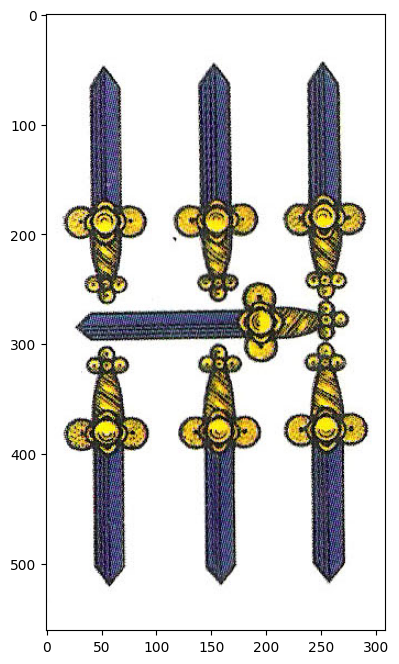

In [3]:
image = cv2.imread('Images/Cards/7S.jpg')

#image = cv2.imread('Images/pollo.png')
print_image(image)

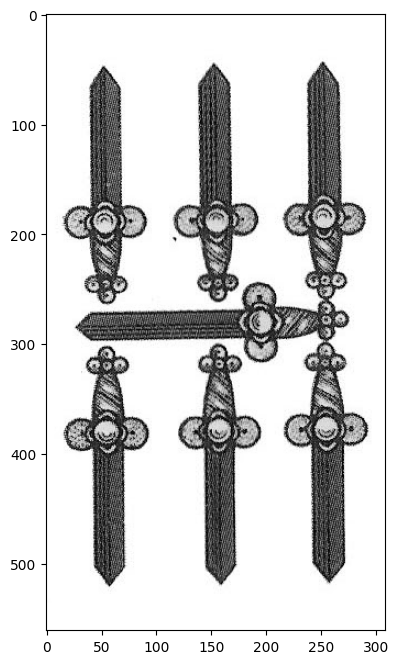

In [4]:
gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
print_image(gray_image)

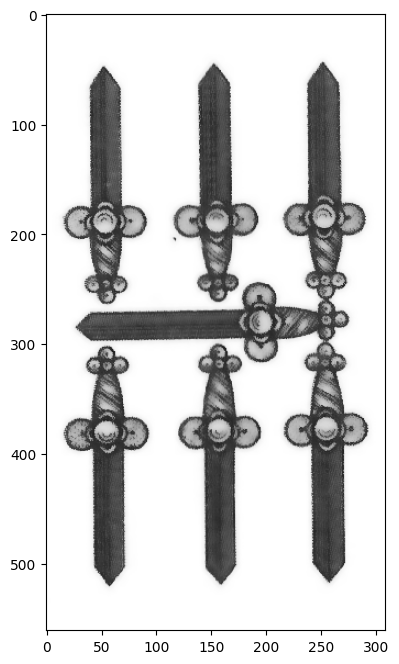

In [5]:

#median_image = cv2.medianBlur(gray_image,3)
median_image = cv2.bilateralFilter(gray_image,9,75,75)
print_image(median_image)


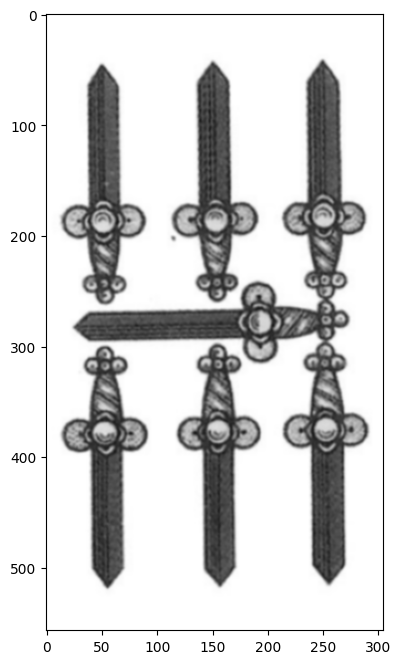

In [6]:
d=2
#TODO sperimentare con l'edge preserving filter
img_gaussian = cv2.GaussianBlur(gray_image, (2*d+1, 2*d+1), -1)[d:-d,d:-d]
print_image(img_gaussian)

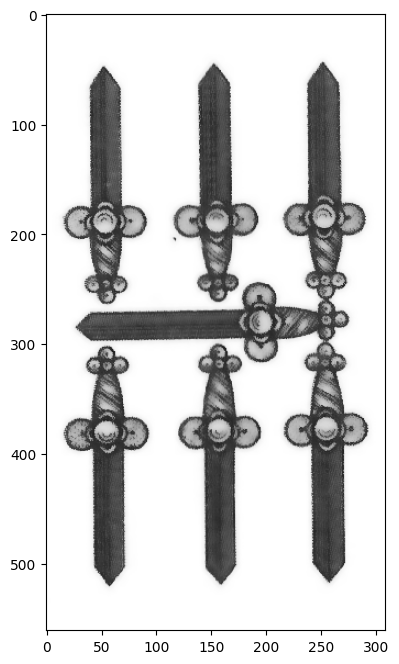

In [7]:

#img_sobel = filters.sobel(gray_image)
img_contrasty_post_median = cv2.convertScaleAbs(median_image, 1.9, 1)
print_image(img_contrasty_post_median)


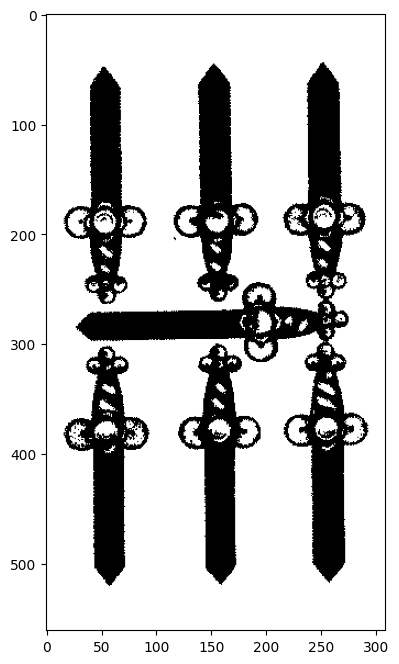

In [8]:
th, binary_image = cv2.threshold(img_contrasty_post_median, 155, 255, cv2.THRESH_BINARY)
#_, binary_image = cv2.threshold(img_sobel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#th, binary_image = cv2.threshold(gray_image, 240, 255, cv2.THRESH_BINARY)

print_image(binary_image)



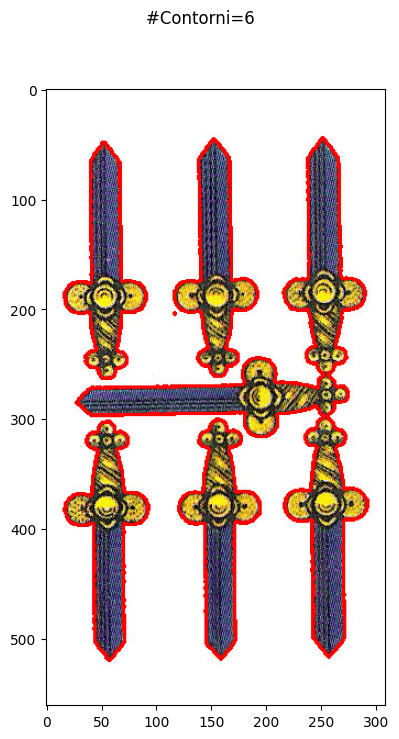

In [9]:
contours, _ = cv2.findContours(image_inversion(binary_image), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#find contours works on black background image
# Create a copy of the original image to draw on
image_with_contours = image.copy()

# Draw contours on the image
cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 2)  # You can adjust the color and thickness
print_image(image_with_contours,"#Contorni={} ".format(str(len(contours))))
#con filtro Gaussiano rileva una quantità minore di contorni

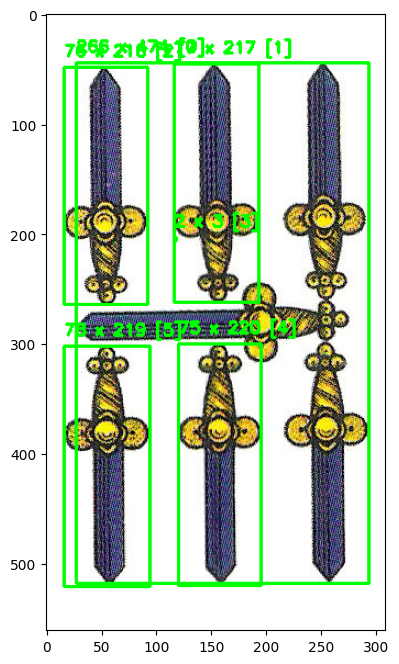

In [10]:

# Create a copy of the original image to draw on
image_with_contours = image.copy()
i=0

for contour in ut.reverse_tuple(contours):
    # Get the bounding box around the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Draw the bounding box
    cv2.rectangle(image_with_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display dimensions near the bounding box
    cv2.putText(image_with_contours, f"{w} x {h} [{i}]", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    i= i+ 1

print_image(image_with_contours)


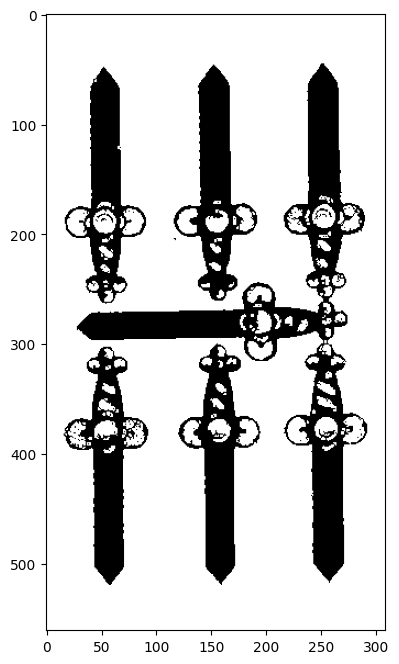

In [11]:
# Detect edges using Canny
edgeresult=binary_image.copy()
edges = cv2.Canny(binary_image, 1, 3)
edgeresult[edges!=0]=(255)

print_image(edgeresult)

In [12]:
moments = cv2.moments(contours[0])
hu_moments = cv2.HuMoments(moments).flatten()
print(hu_moments)

[ 4.74225512e-01  1.80262822e-01  7.30519584e-03  4.43102633e-03
  2.52056333e-05  1.88086644e-03 -4.67894747e-07]


In [13]:

areas = []
ordered_contours = sorted(contours, key=cv2.contourArea, reverse=True)

for contour in ordered_contours:
    x, y, w, h = cv2.boundingRect(contour)
    areas.append(w * h)


print('Areas:', areas)

Areas: [126084, 16709, 17082, 16500, 16416, 6]


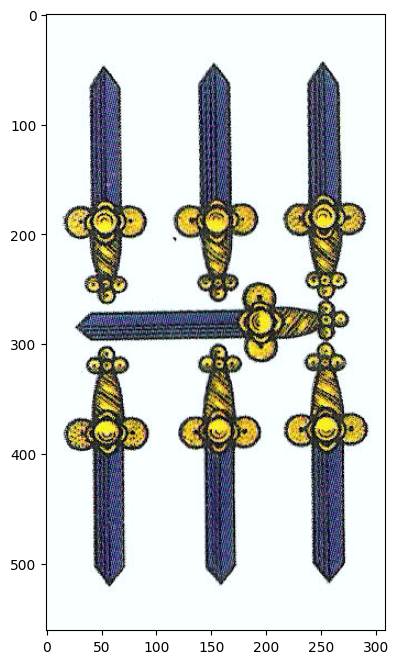

In [14]:
def white_balance(img):
    result = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2BGR)
    return result

print_image(white_balance(image))

Average Hue: 76.97321511037222


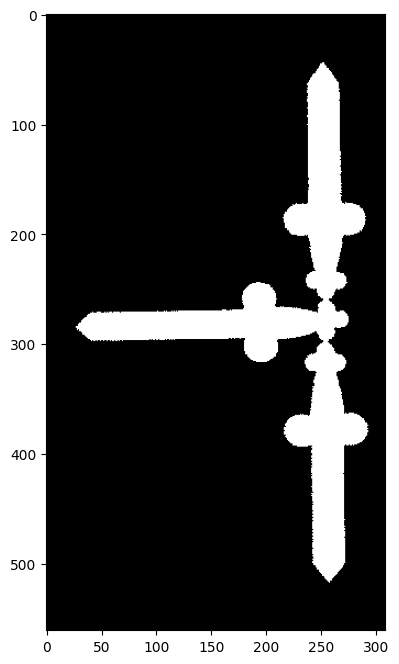

In [15]:
mask = np.zeros((image.shape[0],image.shape[1],), np.uint8)
cv2.drawContours(mask, [ordered_contours[0]], -1, 255, -1)
print_image(mask)
HUE_image = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Calculate the average hue within the masked region
total_hue = 0
pixel_count = 0

for contour in contours:
    # Calculate the average hue for each contour
    area = cv2.contourArea(contour)
    if area > 0:
        mask_roi = np.zeros_like(mask)
        cv2.drawContours(mask_roi, [contour], 0, 255, -1)
        hue_values = HUE_image[..., 0][mask_roi == 255]
        total_hue += np.sum(hue_values)
        pixel_count += len(hue_values)

# Calculate the average hue
if pixel_count > 0:
    average_hue = total_hue / pixel_count
    print("Average Hue:", average_hue)
else:
    print("No pixels found in the masked region.")
